In [1]:
import numpy as np
import math
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)
from scipy.interpolate import griddata

In [39]:
#crs21:00
#cross_start = CoordPair(lat=41.316, lon=-106.57)
#cross_end = CoordPair(lat=41.42, lon=-105.97)
# #####crs22:00
cross_start = CoordPair(lat=41.34, lon=-106.56)
cross_end = CoordPair(lat=41.47, lon=-105.97)
wrf_file = Dataset("/glade/scratch/mingzhu/High_res/WRF/run_e5_turb/wrfout_d03_2006-01-18_19:00:00")
times = 3
u = getvar(wrf_file, "ua",  timeidx = times)
v = getvar(wrf_file, "va", timeidx = times)
w = getvar(wrf_file, "wa", timeidx = times)
ht = getvar(wrf_file, "z", timeidx=times)
ter = getvar(wrf_file, "ter", timeidx=times)
dbz = getvar(wrf_file, "REFL_10CM", timeidx=times)
vice = getvar(wrf_file, "V_ICE", timeidx=times)
##define the function which make variable able to plot on cross-section(interplotion)
def cross(x,des,uni):
    X = 10**(x/10)
    x_cross = vertcross(X, ht, wrfin=wrf_file,start_point=cross_start,end_point=cross_end,latlon=True, meta=True)
    x1_cross = 10.0 * np.log10(x_cross)
    x1_cross.attrs.update(x_cross.attrs)
    x1_cross.attrs["description"] = des
    x1_cross.attrs["units"] = uni
    x_cross_filled = np.ma.copy(to_np(x1_cross))
    for i in range(x_cross_filled.shape[-1]):
        column_vals = x_cross_filled[:,i]
        # Let's find the lowest index that isn't filled. The nonzero function
        # finds all unmasked values greater than 0. Since 0 is a valid value
        # for dBZ, let's change that threshold to be -200 dBZ instead.
        first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
        x_cross_filled[0:first_idx, i] = 0
    return x_cross_filled,x1_cross
###Use function on variable which need to plot
dbz,dbz1 = cross(dbz,'reflectivity', 'dBZ')
ua = cross(u,'U-wind', 'm/s')[0]
va = cross(v,'V-wind', 'm/s')[0]
wa = cross(w,'W-wind', 'm/s')[0]
vice = cross(vice,'Ice Falling Speed','m/s')[0]
###Got axes and terrain value in the map
ter_line = interpline(ter, wrfin=wrf_file, start_point=cross_start,
                      end_point=cross_end)
lats, lons = latlon_coords(u)
cart_proj = get_cartopy(u)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


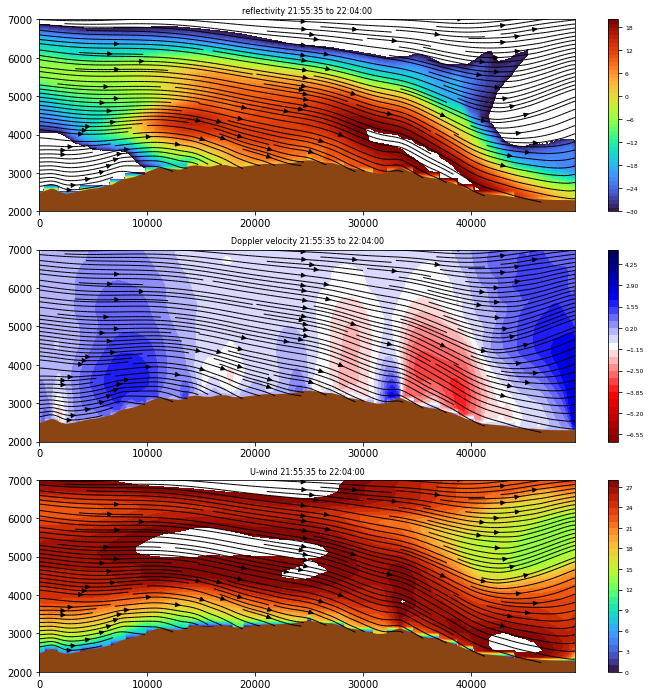

In [42]:
fig = pyplot.figure(figsize=(12,12))
xs = np.arange(0, dbz1.shape[-1], 1)*100
ys = to_np(dbz1.coords["vertical"])
angle = math.radians(14)

def crossplot(cname, x, y, z, levels, colors, title):
    var_fill = cname.contourf(x,y,z, levels = levels, cmap=get_cmap(colors))
    ht_fill = cname.fill_between(x, 0, to_np(ter_line),facecolor="saddlebrown")
    cname.set_ylim([0, 7000])
    cname.set_title(title, fontsize=8)
    cb_cross = fig.colorbar(var_fill, ax=cname)
    cb_cross.ax.tick_params(labelsize=6)
    s1 = cname.streamplot(to_np(x), to_np(y),
                          to_np(ua * math.cos(angle) + va * math.sin(angle)),
                          to_np(wa - vice), density = 5., linewidth=1,
                          color = 'k')
    cname.set_ylim([2000, 7000])
    
ax_ref = fig.add_subplot(3, 1, 1)
ax_w = fig.add_subplot(3, 1, 2)
ax_hori = fig.add_subplot(3, 1, 3)

crossplot(ax_ref,xs,ys,dbz,np.arange(-30., 21, 1),"turbo",'reflectivity 21:55:35 to 22:04:00')
crossplot(ax_w,xs,ys,wa,np.arange(-7., 5.45, .45),"seismic_r",'Doppler velocity 21:55:35 to 22:04:00')
crossplot(ax_hori,xs,ys,ua*math.cos(angle),np.arange(0., 29., 1.),"turbo",'U-wind 21:55:35 to 22:04:00')
pyplot.savefig('e5/ref_dopp_hori_22.png',facecolor='white')

<Figure size 432x288 with 0 Axes>